# Изследователски анализ на данните (EDA)

## Разпознаване на емоции - FER2013

В този notebook ще:

1. Заредим данните
2. Преброим изображенията по класове
3. Визуализираме примерни снимки
4. Проверим размерите и формата на изображенията

## 1. Импортиране на библиотеки

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

## 2. Зареждане на данните

Данните са организирани в папки по емоции:

```
data/
├── train/
│   ├── angry/
│   ├── disgust/
│   └── ...
└── test/
    └── ...
```

In [23]:
TRAIN_DIR = '../data/train'
TEST_DIR = '../data/test'

EMOTIONS = os.listdir(TRAIN_DIR)
print(f"Емоции: {EMOTIONS}")
print(f"Брой класове: {len(EMOTIONS)}")

Емоции: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Брой класове: 7


## 3. Разпределение по класове

Важно е да проверим дали има баланс между класовете. Ако един клас има много повече изображения от друг, моделът може да бъде предубеден.

In [24]:
# Преброяване на изображенията - Train
train_counts = {}
for emotion in EMOTIONS:
    path = os.path.join(TRAIN_DIR, emotion)
    count = len(os.listdir(path))
    train_counts[emotion] = count

print("TRAIN данни:")
for emotion, count in train_counts.items():
    print(f"  {emotion}: {count}")
print(f"  Общо: {sum(train_counts.values())}")

# Преброяване на изображенията - Test
test_counts = {}
for emotion in EMOTIONS:
    path = os.path.join(TEST_DIR, emotion)
    count = len(os.listdir(path))
    test_counts[emotion] = count

print(f"\nTEST данни:")
for emotion, count in test_counts.items():
    print(f"  {emotion}: {count}")
print(f"  Общо: {sum(test_counts.values())}")

TRAIN данни:
  angry: 3995
  disgust: 436
  fear: 4097
  happy: 7215
  neutral: 4965
  sad: 4830
  surprise: 3171
  Общо: 28709

TEST данни:
  angry: 958
  disgust: 111
  fear: 1024
  happy: 1774
  neutral: 1233
  sad: 1247
  surprise: 831
  Общо: 7178


### Визуализация на разпределението

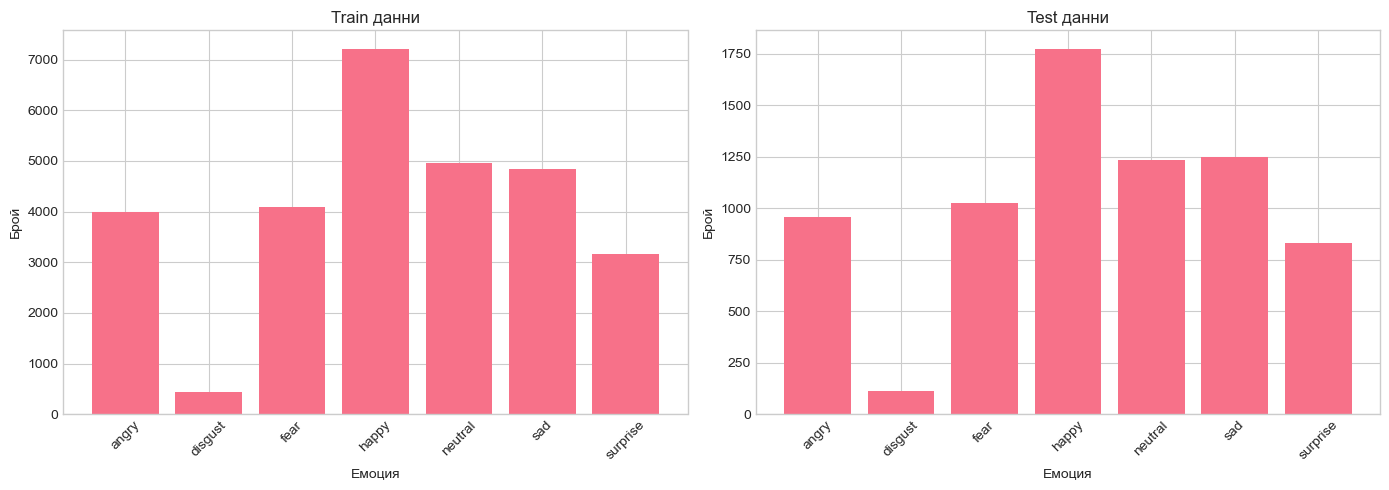

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].bar(train_counts.keys(), train_counts.values())
axes[0].set_title('Train данни')
axes[0].set_xlabel('Емоция')
axes[0].set_ylabel('Брой')
axes[0].tick_params(axis='x', rotation=45)

# Test
axes[1].bar(test_counts.keys(), test_counts.values())
axes[1].set_title('Test данни')
axes[1].set_xlabel('Емоция')
axes[1].set_ylabel('Брой')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Анализ на дисбаланса

In [27]:
max_emotion = max(train_counts, key=train_counts.get)
min_emotion = min(train_counts, key=train_counts.get)

max_count = train_counts[max_emotion]
min_count = train_counts[min_emotion]
ratio = max_count / min_count

print(f"Най-голям клас: {max_emotion} ({max_count} изображения)")
print(f"Най-малък клас: {min_emotion} ({min_count} изображения)")
print(f"Съотношение: {ratio:.1f}x")

Най-голям клас: happy (7215 изображения)
Най-малък клас: disgust (436 изображения)
Съотношение: 16.5x


## 4. Примерни изображения

Нека видим как изглеждат изображенията от всеки клас.

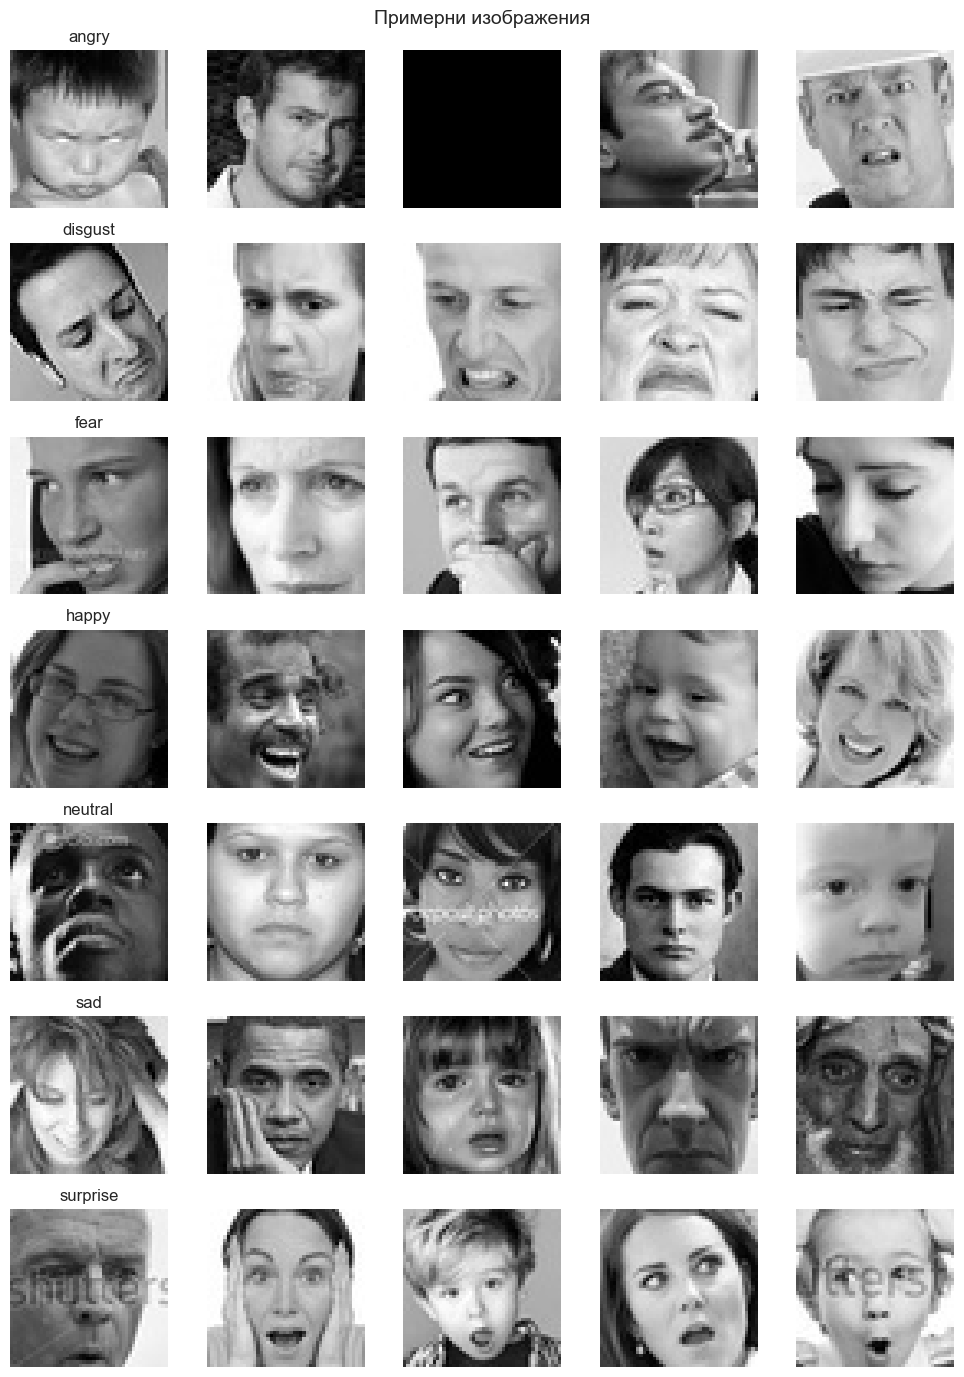

In [28]:
fig, axes = plt.subplots(len(EMOTIONS), 5, figsize=(10, 14))

for i, emotion in enumerate(EMOTIONS):
    emotion_path = os.path.join(TRAIN_DIR, emotion)
    images = os.listdir(emotion_path)[:5]
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(emotion_path, img_name)
        img = Image.open(img_path)
        
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        
        if j == 0:
            axes[i, j].set_title(emotion)

plt.suptitle('Примерни изображения', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Свойства на изображенията

Проверяваме размера и формата на изображенията.

In [29]:
# Зареждаме едно примерно изображение
sample_path = os.path.join(TRAIN_DIR, EMOTIONS[0])
sample_file = os.listdir(sample_path)[0]
sample_img = np.array(Image.open(os.path.join(sample_path, sample_file)))

print(f"Размер: {sample_img.shape}")
print(f"Тип данни: {sample_img.dtype}")
print(f"Мин. стойност: {sample_img.min()}")
print(f"Макс. стойност: {sample_img.max()}")

Размер: (48, 48)
Тип данни: uint8
Мин. стойност: 3
Макс. стойност: 197


## 6. Заключение

### Основни наблюдения

От анализа на данните установихме следното:

| Характеристика | Стойност |
|----------------|----------|
| Брой класове | 7 емоции |
| Train изображения | 28,709 |
| Test изображения | 7,178 |
| Размер на изображенията | 48 x 48 пиксела |
| Цветови формат | Grayscale (черно-бяло) |
| Тип данни | uint8 (цели числа от 0 до 255) |

**Забележка:** Test данните ще използваме само за финална оценка на модела. По време на обучение ще разделим train данните на train/validation.

### Дисбаланс на класовете

Това е **сериозен проблем** в нашите данни:

- **Най-голям клас:** happy (7,215 изображения)
- **Най-малък клас:** disgust (436 изображения)  
- **Съотношение:** 16.5x разлика

Това означава, че ако моделът предвижда "happy" за всяко изображение, ще има ~25% точност само заради дисбаланса. Трябва да използваме:
- **Class weights** - даваме по-голяма тежест на малките класове
- **F1-score** вместо accuracy за оценка

### Стойностите на пикселите са от 0 до 255?

Типът данни `uint8` (unsigned 8-bit integer) може да съхранява стойности от 0 до 255. Това е стандартът за изображения:
- **0** = черно (липса на светлина)
- **255** = бяло (максимална светлина)

В секция 5 видяхме, че конкретното изображение има стойности между 3 и 197, но други изображения могат да имат различни диапазони в рамките на 0-255.

### Предварителна обработка (preprocessing)

Преди да подадем данните на модела, трябва да:

1. **Нормализираме пикселите** - делим на 255, за да получим стойности между 0 и 1
2. **Reshape за CNN** - променяме формата от (48, 48) на (48, 48, 1) за да добавим channel dimension


### Следващи стъпки

- Да заредим всички изображения в numpy масиви
- Да приложим нормализация